In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.image as mpimg
import folium
import networkx as nx
import osmnx as ox


# 1. Graph creation

Firstly, import the network using OSMnx and do a bit of data clearning. Node that the graph is MultiGraph, there are 2 paths between two point.

In [4]:
# Import Manhattan network and change node labels to integers
G = ox.graph_from_place('Manhattan, New York, USA', network_type='drive')



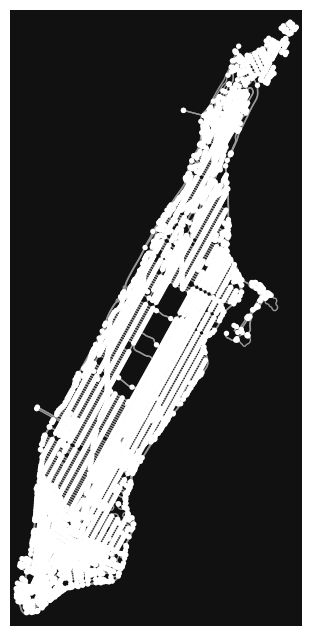

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
# If a node cannot access at least 10% of other nodes, delete it (isolated points are not considered)
remove_list = []
num_nodes = len(G.nodes)
for node in G.nodes:  
    reach = len(nx.descendants(G, node))
    if reach < num_nodes / 10:
        remove_list.append(node)

for node in remove_list:
    G.remove_node(node)

G = nx.convert_node_labels_to_integers(G, label_attribute='old_node_ID')

ox.plot_graph(G)

Have a brief understanding of the graph we create

In [10]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f'The graph has {num_nodes} nodes and {num_edges} edges')

The graph has 4551 nodes and 9797 edges


 File **'graph_network_map'** show the plot of the graph 

# 2. Add travel time as properties of each edge

In this section, we use the Uber movenment data in June, 2019 to get the travel time of each edges, then we use function to get the shortest travel time between each two nodes in the graph. 

In [ ]:
G = ox.add_edge_speeds(G)

Then import the Uber Movenment data and covert to a dictionary with OSM Way IDs and hour of the day as keys. Note that each osm_way_id has 24 speeds in a 24-hour period, with with significant differences in speed during periods. This reflect traffic conditions during peak and off-peak hours.

In [ ]:
speed_df_path = r"C:\Users\yanzh\Desktop\Code\archive\nyc_avg_speeds_2019-06.csv"
speed_df = pd.read_csv(speed_df_path)
speed_df = speed_df[['osm_way_id', 'hour', 'speed']]
speed_df

Append the distance/speed of each edge in the graph to the graph properties as travel time, here we use speed of each hour, so we can get 24 sets graph includinig different travel time propoties.

Note that the code below takes too long time to run, so it is necessary to store the result. 

In [ ]:
# import copy

# graphs = [copy.deepcopy(G) for _ in range(24)]

# # Go through each hour from 0 to 24 h
# for hour in range(24):
#     hour_speed_df = speed_df[speed_df['hour'] == hour]
    
#     # Go through each speed data in this hour
#     for index, row in hour_speed_df.iterrows():
#         osm_way_id = row['osm_way_id']
#         speed = row['speed'] * 1.60934  # convert the speed from kph

#         # Go through each edges in the graph
#         for edge in graphs[hour].edges(keys=True, data=True):  # Include keys=True to handle multiple edges
#             u, v, key, edge_data = edge

#             if 'osmid' in edge_data:
#                 if isinstance(edge_data['osmid'], int) and edge_data['osmid'] == osm_way_id or \
#                    isinstance(edge_data['osmid'], list) and osm_way_id in edge_data['osmid']:
#                     # Calculate the travel time and update the specific edge
#                     distance_km = edge_data['length'] / 1000  # Convert meters to kilometers
#                     travel_time_minutes = (distance_km / speed) * 60  # Travel time in minutes
#                     graphs[hour][u][v][key]['travel_time_hour_{}'.format(hour)] = travel_time_minutes

#     first_edge_data = list(graphs[hour].edges(data=True))[0][2]  # Get the data of the first edge
#     first_edge_travel_time = first_edge_data.get('travel_time_hour_{}'.format(hour), 'No data')
#     print(f"Hour {hour}: The first edge's travel time is {first_edge_travel_time}")

Here there are some edges lacking of travel time data, here we substitute this with the free flow travel data.

In [ ]:
# G = ox.add_edge_travel_times(G, precision=1)

# # Go through the graoh in each hour
# for hour in range(24):
#     for u, v, data in graphs[hour].edges(data=True):
#         travel_time_key = f'travel_time_hour_{hour}'

#         if travel_time_key not in data:
#            freeflow_travel_time = G[u][v][0].get('travel_time', None)
#            if freeflow_travel_time is not None:
#                graphs[hour][u][v][0][travel_time_key] = freeflow_travel_time

In [ ]:
# import pickle

# def save_graph_as_pkl(graph, file_path):
#     """
#     Save a graph to a file using pickle.
    
#     Parameters:
#     - graph: A NetworkX graph or a list of NetworkX graphs to be saved.
#     - file_path: The path (including filename) where the graph should be saved.
#     """
#     with open(file_path, "wb") as f:
#         pickle.dump(graph, f)



# # Example usage for saving a list of graphs:
# save_graph_as_pkl(graphs, "graphs_list.pkl")


See **"graphs.pkl"** as result

Next we read the graph

In [ ]:
# Load the graphs data in the file
import pickle

# Load the graphs data in the file
def load_graph_from_pkl(file_path):

    with open(file_path, "rb") as f:
        graph = pickle.load(f)
    return graph

# Example usage for loading a list of graphs:
graphs = load_graph_from_pkl("graphs_list.pkl")

# 3. Define the function to calculate the shortest time

Here define the function to calculate the shortest time and show the shortest path in the plot.

Here we use Dijkstra algorithm, that is, the shortest path from the specific origin node to all other nodes in the graph. This function is especially suitable for graphs with weights (here is travel time), and especially when the edge weight is non-negative. And it is able to return the shortest travel time and the path itself.

In [ ]:
# Define the travel time function using Dijkstra algorithm
def travel_time_func(G_hour, point1, point2, hour):
    try:
        # Define the weight key for the specific hour
        weight_key = f'travel_time_hour_{hour}'

        # Use Dijkstra's algorithm to find the shortest path length and path
        # This function returns both the length of the path and the actual path as a list of nodes
        # Here function is from NetworkX library, the 'source' and 'target' parameters are expected to be the 
        # node identifies from the graph.
        travel_time, path = nx.single_source_dijkstra(G_hour, source=point1, target=point2, weight=weight_key)

        # Round the travel time to 2 decimal places
        travel_time = round(travel_time, 4)

        return travel_time, path
    except nx.NetworkXNoPath:
        
        # If there is no path between point1 and point2, return inf for travel_time and an empty path
        return float('inf'), []

Next is a simple example. This example illustrates how to calculate the shortest travel time and visualize the routh with shortest travel time

In [ ]:
travel_time, path = travel_time_func(graphs[0], list(G.nodes())[19], list(G.nodes())[165], 0)

print(f'The shortest travel time is {travel_time} mins')
if path:
    fig, ax = ox.plot_graph_route(G, path, route_color='blue', node_size=0, bgcolor='k')

In [ ]:
s

# 4. Choose the potential location of EV charging station

Firstly, we put each potential EV chagring station at each operational area of taxi. Initially, EV charging stations are put at some popular area like notable landmarks, hosipitals and universities. Moreover, I also take into consideration the layout of Tesla's charging infrastructure in Manhatton, which makes it close to the reality.

Then I find the nearest node in the graph to the location I specified.

In [ ]:
# Load the EV charging station location
ev_station_path = r"C:\Users\yanzh\Desktop\Code\archive\Potential EV stations.xlsx"
df_ev_station = pd.read_excel(ev_station_path)

# Find the nearest node cloest to each point
nearest_nodes = df_ev_station.apply(lambda x: ox.nearest_nodes(G, X=x['longitude'], Y=x['latitude']), axis=1)

In [ ]:
nearest_nodes_coords = []

for node_id in nearest_nodes:
    node_data = G.nodes[node_id]

    lat, lon = node_data['y'], node_data['x']

    nearest_nodes_coords.append((lat, lon))
    
df_nearest_nodes_coords = pd.DataFrame(nearest_nodes_coords, columns=['latitude', 'longitude'])
df_nearest_nodes_coords

In [ ]:
df_nearest_nodes_coords.to_csv('coordinates of charging station.csv')


Then we visualize the html map to show details.

In [ ]:
# Read the shapefile
shapefile_path = r"C:\Users\yanzh\Desktop\Code\archive\taxi_zones\taxi_zones.shp"
gdf = gpd.read_file(shapefile_path)

# Ensure the GeoDataFrame is in WGS84 (EPSG:4326)
gdf = gdf.to_crs(epsg=4326)

# Filter Manhattan zone
manhattan_gdf = gdf[gdf['borough'] == 'Manhattan']

# Creaet a base map
m = folium.Map(location=[40.7831, -73.9712], zoom_start=12, tiles='cartodbpositron')

# Add polygons to the map and annotate each zone with its Location ID
for _, row in manhattan_gdf.iterrows():

    # Here remove the zone where the location id is 103
    if row['LocationID'] == 103 or row['LocationID'] == 202:
        continue
    geom = row['geometry']
    location_id = row['LocationID']  # Ensure 'LocationID' matches the column name in your GeoDataFrame
    if geom.geom_type == 'Polygon':
        polygons = [geom]
    elif geom.geom_type == 'MultiPolygon':
        polygons = geom.geoms
    else:
        continue

    for polygon in polygons:
        exterior_coords = [[(lat, lon) for lon, lat in polygon.exterior.coords]]
        folium.Polygon(
            locations=exterior_coords,
            color='blue',
            weight=1.5,
            fill=True,
            fill_color='#99d8ff',
            fill_opacity=0.7
        ).add_to(m)
    
    # Use 'location_id' which is defined within the loop
    folium.Marker(
        location=[geom.centroid.y, geom.centroid.x],
        icon=folium.DivIcon(html=f"<div style='font-size: 8pt; color:  #666666;'>{location_id}</div>")
    ).add_to(m)

# Add markers for each EV charging station from the excel file
for idx, row in df_nearest_nodes_coords.iterrows():
    lat, lon = row[0], row[1]
    ev_station_id = idx+1

    folium.Marker(
        location=[lat, lon],
        popup=f'{ev_station_id}',
        icon=folium.Icon(color='red', icon='bolt', prefix='fa')
    ).add_to(m)

# m


In [ ]:
m.save('Network EV Charging Station map.html')

See **'EV Charging Station map.html'** file (After adjusting to nearest node) 

See **'Network EV Charging Station map.html'** file (After adjusting to nearest node) 

Then caclucate the travel time between every two stations points, with function defined before.

Next is a simple example

In [ ]:
point1_coords = df_nearest_nodes_coords.iloc[64]
point1_node = ox.nearest_nodes(graphs[1], X=point1_coords['longitude'], Y=point1_coords['latitude'])
point1_node

In [ ]:
point1_coords = df_nearest_nodes_coords.iloc[34]
point2_coords = df_nearest_nodes_coords.iloc[56]
point1_node = ox.nearest_nodes(graphs[10], X=point1_coords['longitude'], Y=point1_coords['latitude'])
point2_node = ox.nearest_nodes(graphs[10], X=point2_coords['longitude'], Y=point2_coords['latitude'])

travel_time, path = travel_time_func(graphs[10], point1_node, point2_node, 10)

print(f'The shortest travel time is {travel_time} mins')
if path:
    fig, ax = ox.plot_graph_route(G, path, route_color='blue', node_size=0, bgcolor='k')